In [40]:
#import necessary library & settings
import torch
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import warnings
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
#HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00 ", "#FF006D", "#ADFF02", "#8F00FF"]
#sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
warnings.filterwarnings('ignore')

cuda:0


## Load Dataset

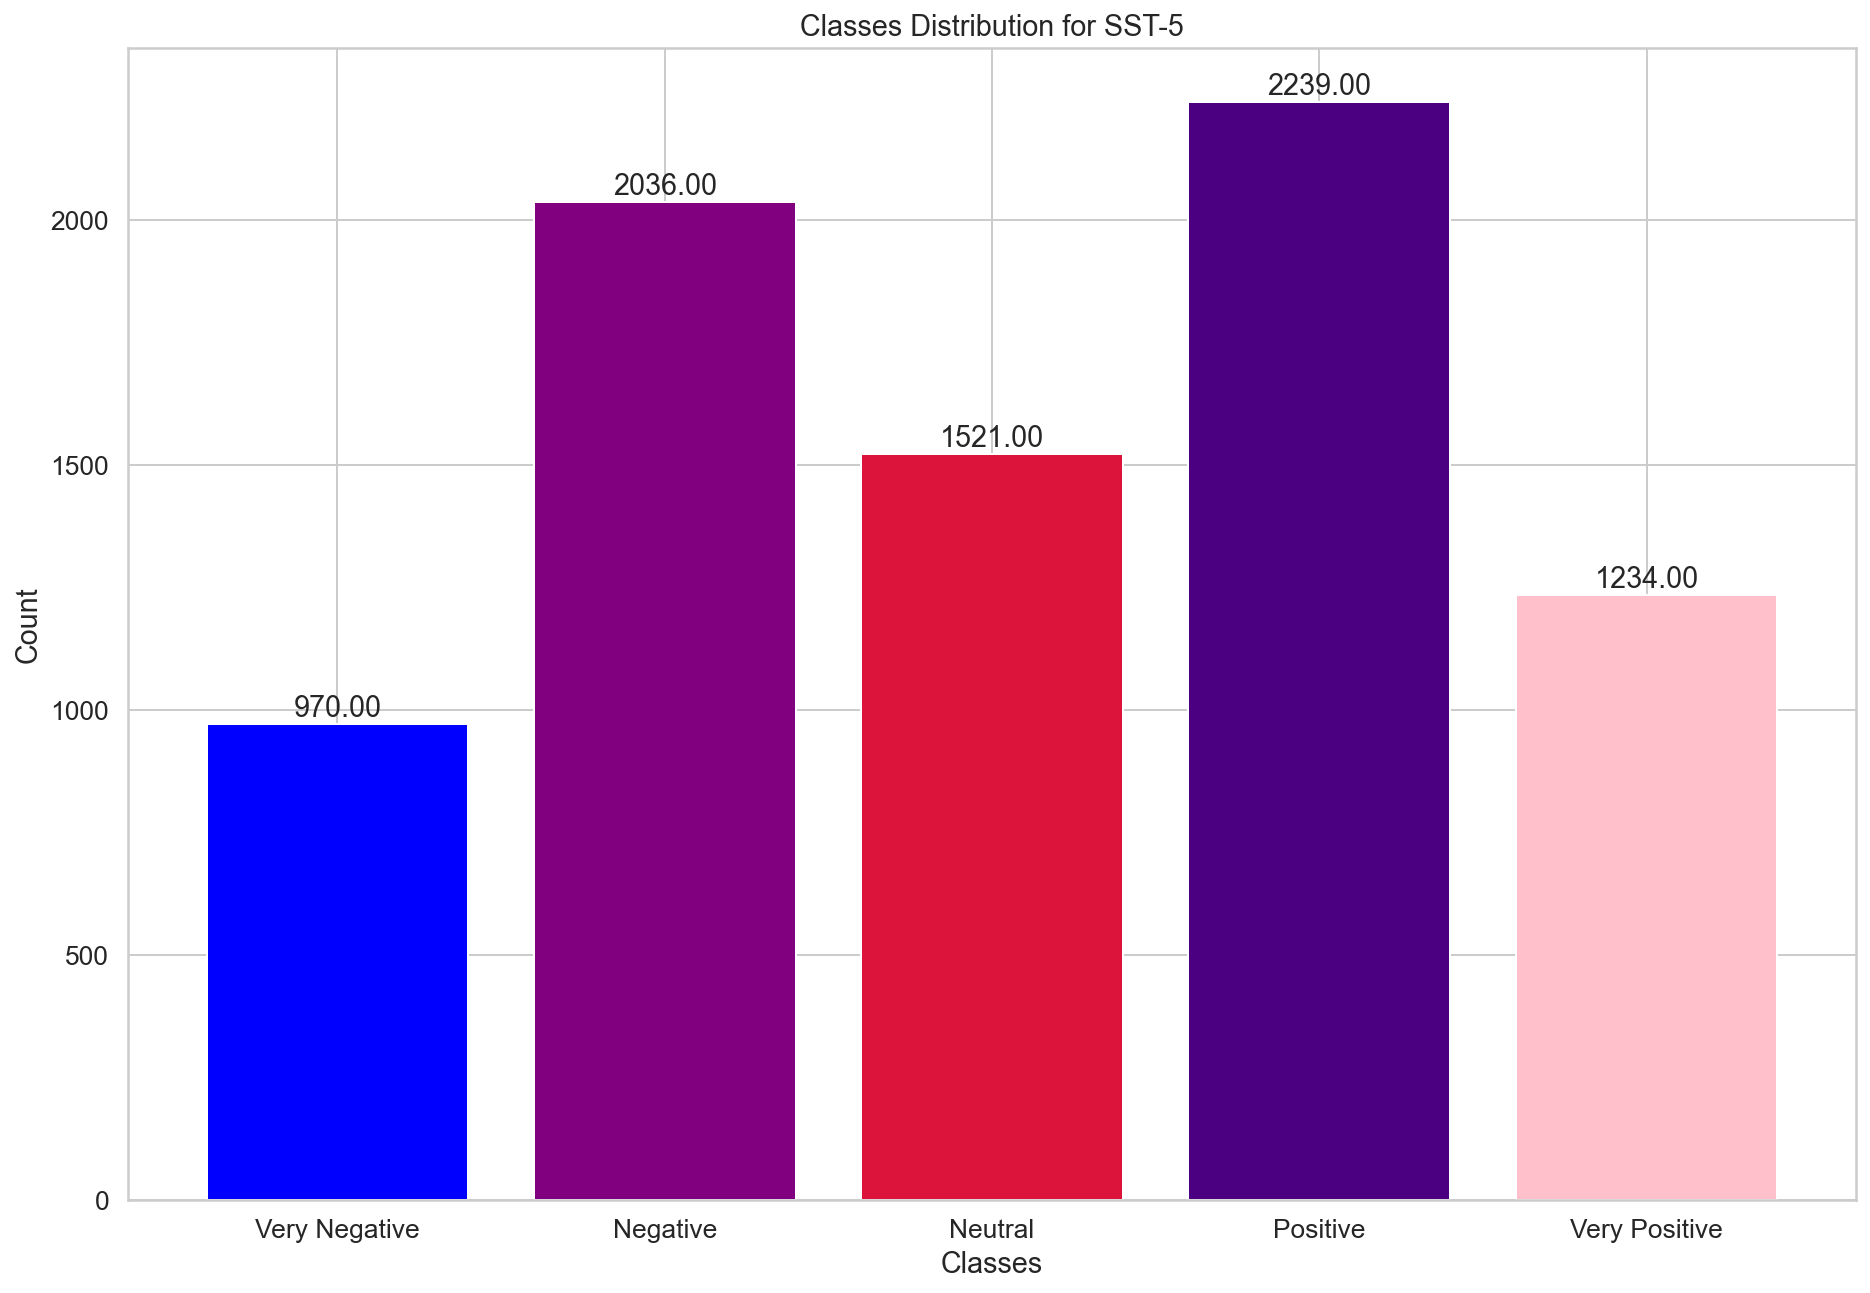

In [41]:
import pandas as pd
# Read train data
df = pd.read_csv('C:/Users/Yuheng/sst_train.txt', sep='\t', header=None, names=['truth', 'text'],encoding='latin-1')
df = df[:8000]
df['truth'] = df['truth'].str.replace('__label__', '')
df['truth'] = df['truth'].astype(int).astype('category')

Vnegative=0
negative=0
positive=0
Vpositive=0
neutral=0

for i in range (8000):
    #print(df['truth'][i])
    if(df['truth'][i]==1):
        Vnegative=Vnegative+1
    elif(df['truth'][i]==2):
        negative=negative+1
    elif(df['truth'][i]==3):
        neutral=neutral+1
    elif(df['truth'][i]==4):
        positive=positive+1
    elif(df['truth'][i]==5):
        Vpositive=Vpositive+1

Classes = ['Very Negative','Negative','Neutral','Positive','Very Positive']
Count = [Vnegative,negative,neutral,positive,Vpositive]
fig = plt.figure()
ax = fig.add_axes([0,2,1,1])
ax.set_xlabel('Classes')
ax.set_ylabel('Count')
ax.set_title('Classes Distribution for SST-5')
width=0.35
x = np.arange(len(Count))
rects1 = ax.bar(x - width/2, Count, width)
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 1, height),
                    xytext=(0, 1),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
rects1 = ax.bar(x - width/2, Count, width)
autolabel(rects1)
ax.bar(Classes,Count,color=[ 'blue', 'purple', 'crimson','indigo','pink'])
plt.show()

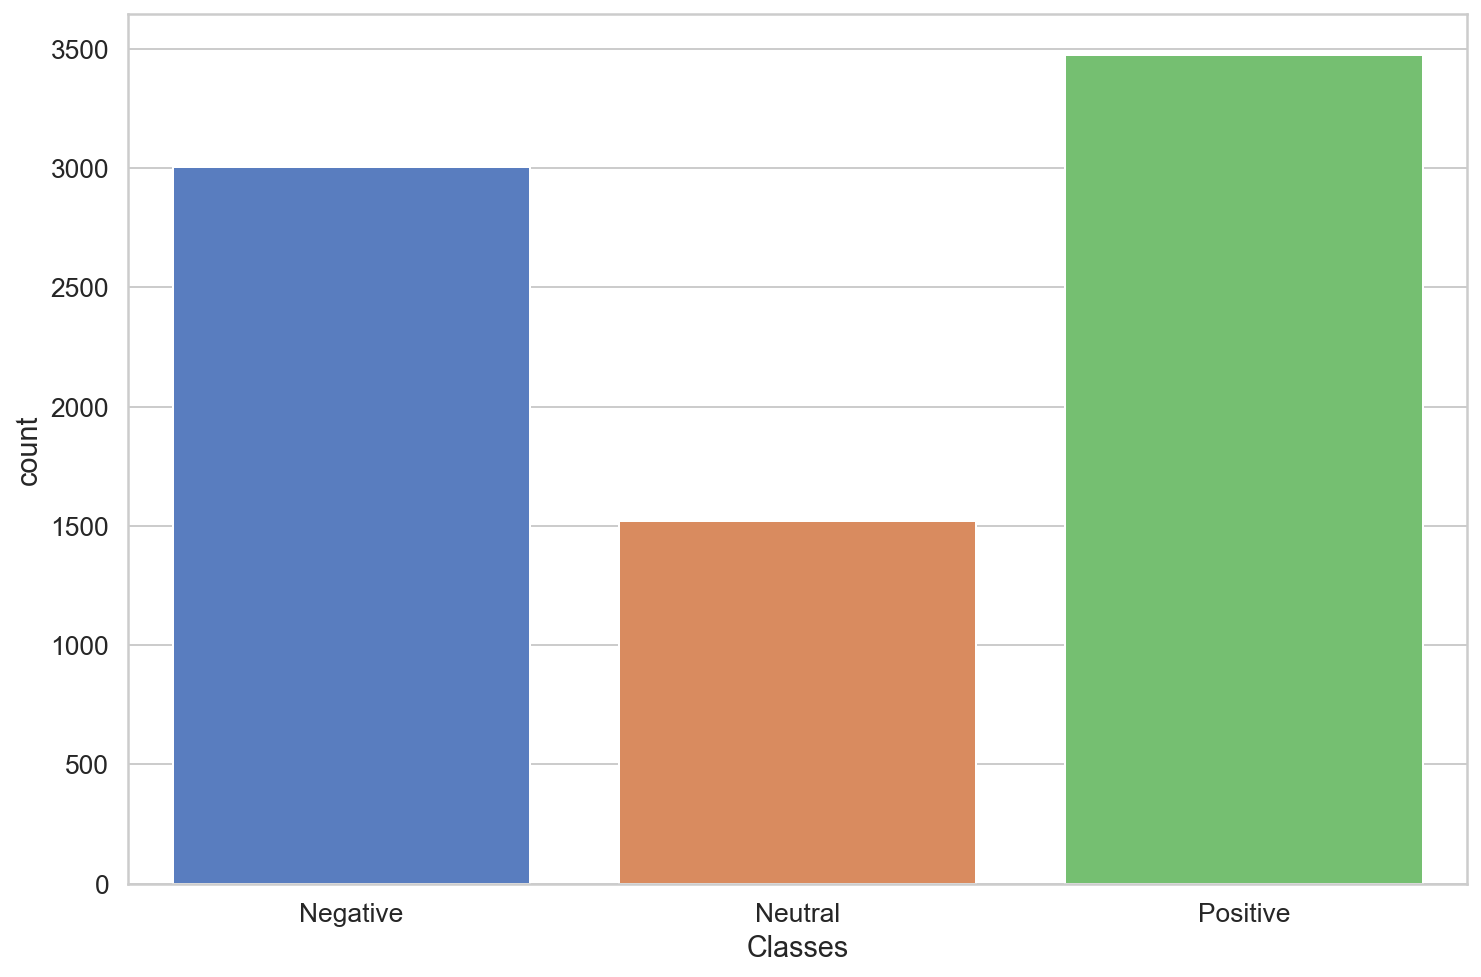

In [42]:
def to_sentiment(rating):
  rating = int(rating)
  if rating == 1:
    return 0
  elif rating == 2:
    return 0
  elif rating == 3:
    return 1
  elif rating == 4:
    return 2
  else:
    return 2
df['truth'] = df.truth.apply(to_sentiment)
class_names = ['Negative','Neutral','Positive']
ax = sns.countplot(df.truth)
plt.xlabel('Classes')
ax.set_xticklabels(class_names);


In [43]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [44]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [45]:
class_names = ['Negative','Neutral', 'Positive']
#model = SentimentClassifier(len(class_names))
model = bert_model.to(device)

In [46]:
#extract CLS token for every sentence
import time
start_time = time.time()
encoded_text=[]
for i in range (0,len(df['text'])):
    encoded_review = tokenizer.encode_plus(
      df['text'][i],
      max_length=512,
      truncation=True,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    feature = last_hidden_states
    features = (feature[0][:,0,:].cpu()).numpy().flatten() #extract the last CLS token from BERT-layer and flatten into 1d array
    encoded_text.append(features)
    #print("--- %s seconds ---" % (time.time() - start_time))
    

In [47]:
labels=df['truth']

In [117]:
x=encoded_text
y=labels

In [82]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
model_DT_50 = DecisionTreeClassifier(max_features=50)
Fit1 = model_DT_50 .fit(x, y)
model_DT_100 = DecisionTreeClassifier(max_features=100)
Fit2 =model_DT_100.fit(x, y)
model_DT_150 = DecisionTreeClassifier(max_features=150)
Fit3 = model_DT_150.fit(x, y)
model_DT_200 = DecisionTreeClassifier(max_features=200)
Fit4 = model_DT_200.fit(x, y)
model_DT_252 = DecisionTreeClassifier(max_features=252) #max=252
Fit5 = model_DT_252.fit(x, y)

768
768
768
768
768
0.8170425756151789


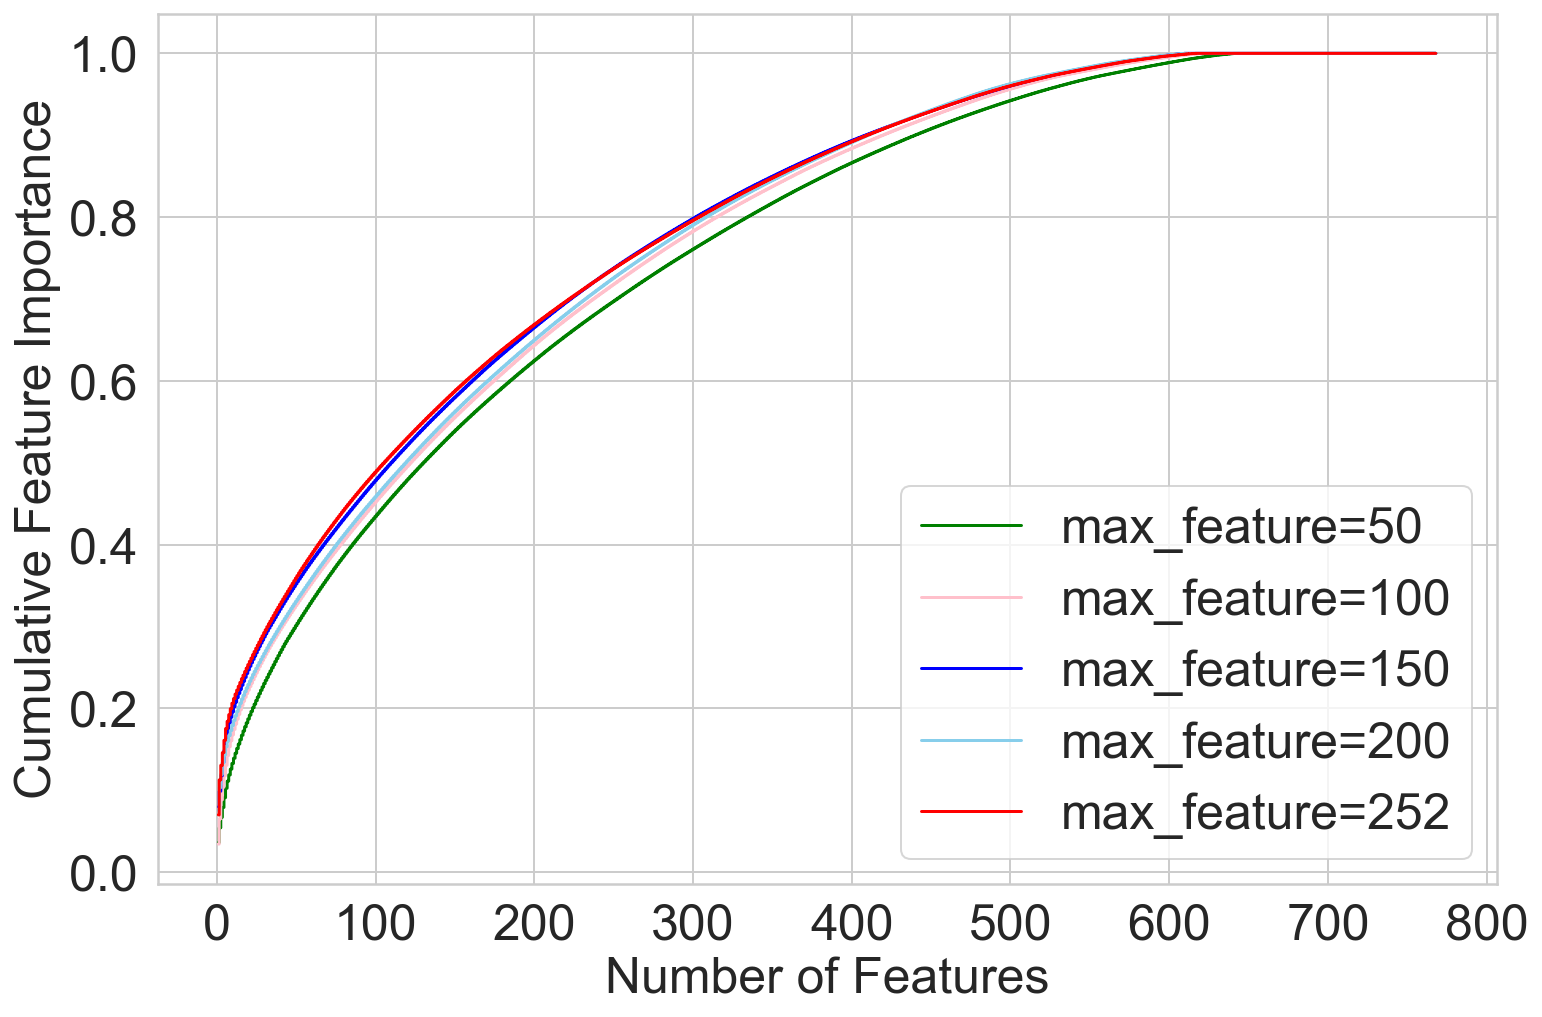

In [138]:
importances1 = Fit1.feature_importances_
indices1 = np.argsort(importances1)[-769:]
indices1[:] = indices1[::-1] # reverse
print(len(indices1))
importances2 = Fit2.feature_importances_
indices2 = np.argsort(importances2)[-769:]
indices2[:] = indices2[::-1] # reverse
print(len(indices2))
importances3 = Fit3.feature_importances_
indices3 = np.argsort(importances3)[-769:]
indices3[:] = indices3[::-1] # reverse
print(len(indices3))
importances4 = Fit4.feature_importances_
indices4 = np.argsort(importances4)[-769:]
indices4[:] = indices4[::-1] # reverse
print(len(indices4))
importances5 = Fit5.feature_importances_
indices5 = np.argsort(importances5)[-769:]
indices5[:] = indices5[::-1] # reverse
print(len(indices5))
sum1=[]
sum2=[]
sum3=[]
sum4=[]
sum5=[]
sum_1=0
sum_2=0
sum_3=0
sum_4=0
sum_5=0
for i in range (0,len(indices1)):
    a=importances1[indices1[i]]
    sum_1=sum_1+a
    if(i==349):
        print(sum_1)
    sum1.append(sum_1)
for i in range (0,len(indices2)):
    a=importances2[indices2[i]]
    sum_2=sum_2+a
    sum2.append(sum_2)
for i in range (0,len(indices3)):
    a=importances3[indices3[i]]
    sum_3=sum_3+a
    sum3.append(sum_3)
for i in range (0,len(indices4)):
    a=importances4[indices4[i]]
    sum_4=sum_4+a
    sum4.append(sum_4)
for i in range (0,len(indices5)):
    a=importances5[indices5[i]]
    sum_5=sum_5+a
    sum5.append(sum_5)

plt.step(range(1,769),sum1, where= 'mid', label='max_feature=50',color='green')
plt.step(range(1,769),sum2, where= 'mid', label='max_feature=100',color='pink')
plt.step(range(1,769),sum3, where= 'mid', label='max_feature=150',color='blue')
plt.step(range(1,769),sum4, where= 'mid', label='max_feature=200',color='skyblue')
plt.step(range(1,769),sum5, where= 'mid', label='max_feature=252',color='red')
plt.ylabel('Cumulative Feature Importance', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Number of Features', fontsize=25)
plt.legend(loc = 'best', fontsize=25)
plt.show()

In [104]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
model_DT = DecisionTreeClassifier(max_features=200)
Fit = model_DT .fit(x, y)

50


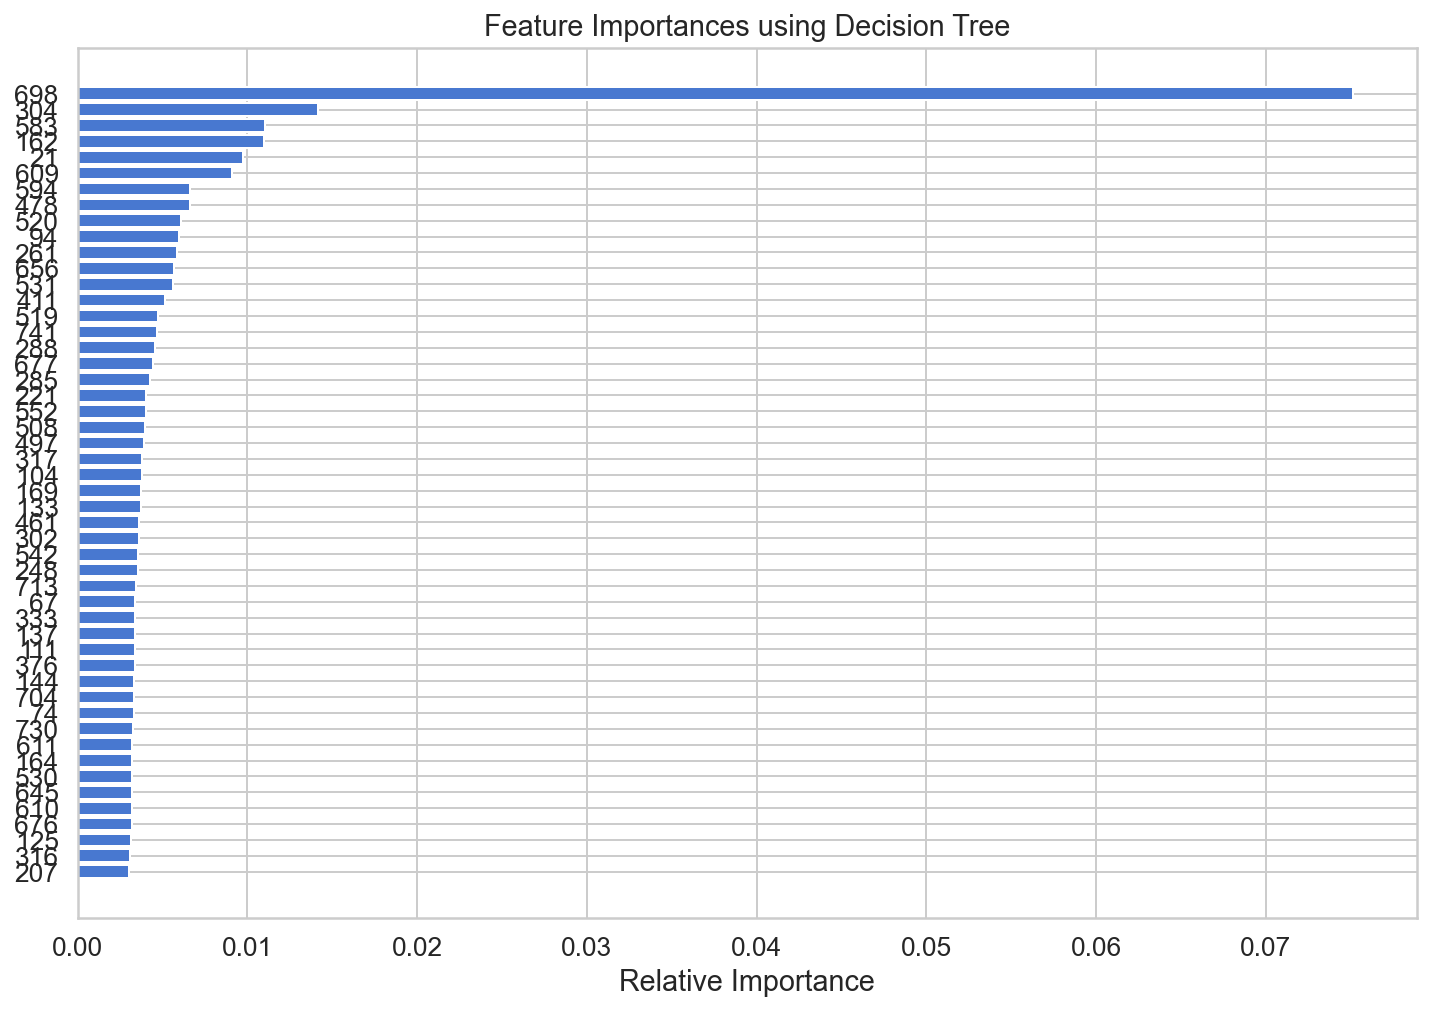

In [102]:
importances = Fit.feature_importances_
indices = np.argsort(importances)[-50:]  # top 50 features
print(len(indices))
plt.title('Feature Importances using Decision Tree')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [indices[i] for i in range(len(indices))])
plt.xlabel('Relative Importance')
plt.show()

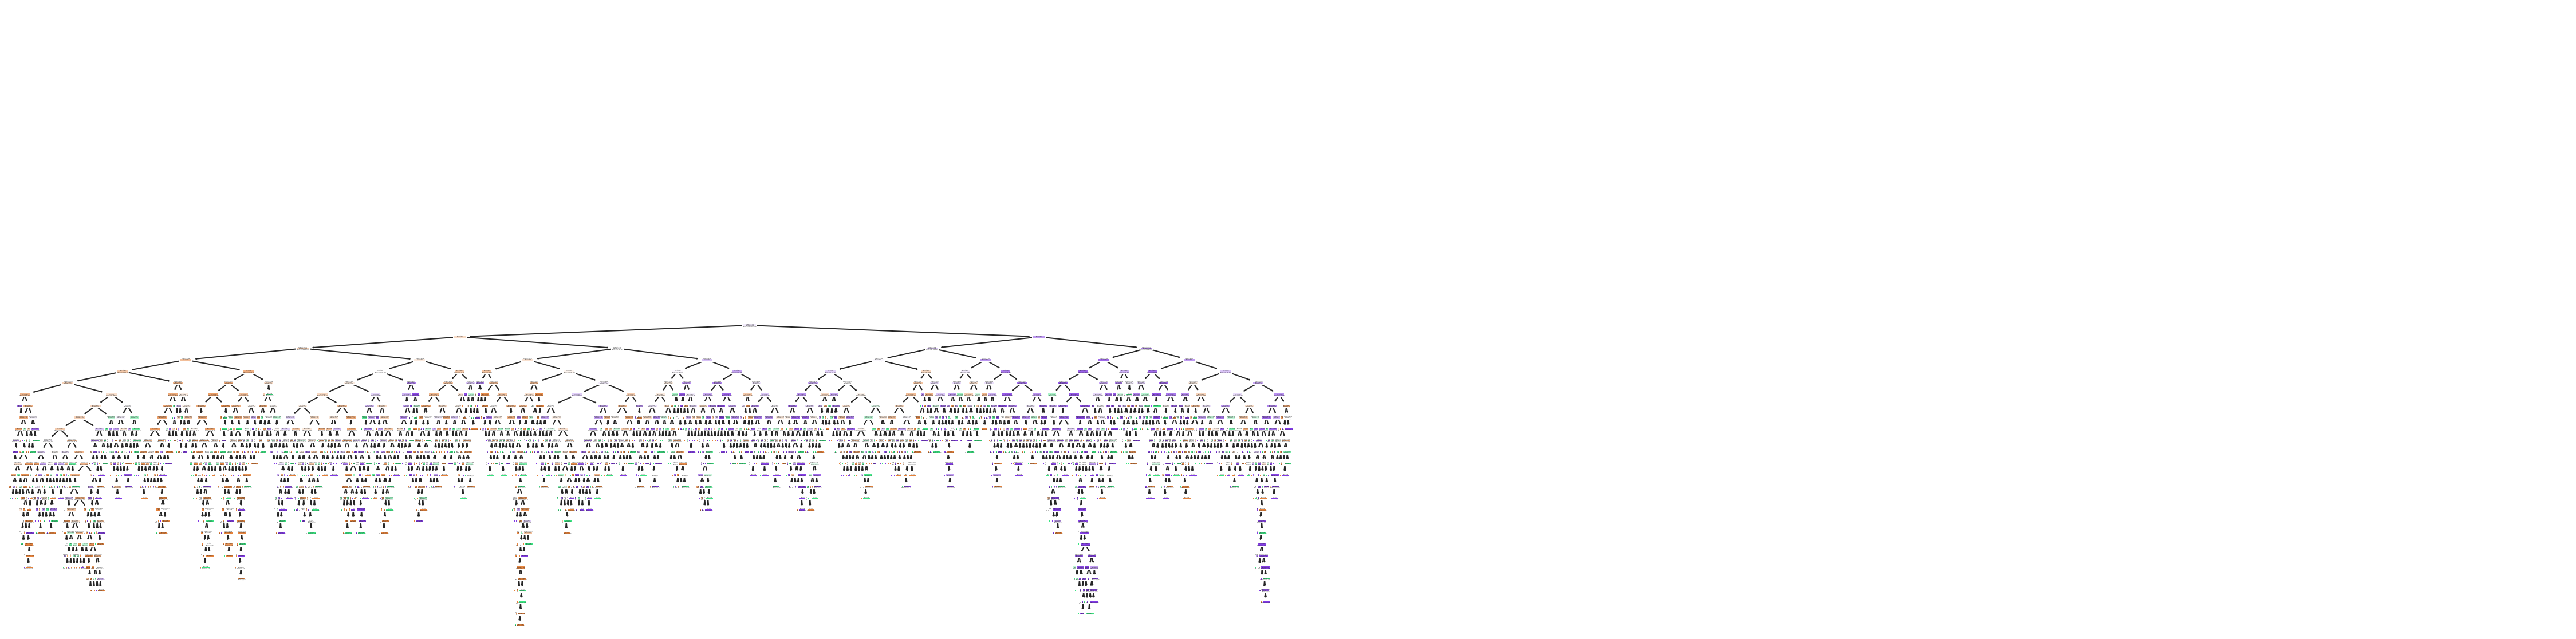

In [101]:
fig = plt.figure(figsize=(40,10))
plot_tree(Fit, filled=True)
plt.show()

In [60]:
reduced_encoded_text = np.delete(encoded_text, [indices], 1)
print(reduced_encoded_text)


[[ 0.24509159  0.19708309  0.29548106 ... -0.29075688  0.72883326
   0.44577336]
 [ 0.09723976  0.09622154 -0.26650718 ... -0.23062071  0.48081025
   0.5357829 ]
 [-0.32416722 -0.10876965 -0.57410985 ... -0.13799219  0.5594007
   0.49791324]
 ...
 [-0.6389676  -0.38434893 -0.39575297 ... -0.51342124  0.54426205
   0.49297243]
 [-0.24634935 -0.35067943  0.18437135 ... -0.3237255   0.7697916
   0.07015157]
 [-0.49031657 -0.47751486 -0.62413853 ... -0.5154614   0.5796705
   0.18884005]]


In [61]:
print(len(reduced_encoded_text[1]))

719


In [63]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import time
start_time = time.time()
X_train_dt, X_test_dt, train_labels_dt, test_labels_dt = train_test_split(reduced_encoded_text, labels)
svc_clf_dt = make_pipeline(StandardScaler(), SVC(gamma='auto'))
svc_clf_dt.fit(X_train_dt,train_labels_dt)
svc_dt_score=svc_clf_dt.score(X_test_dt, test_labels_dt)
print(svc_dt_score)
print("--- %s seconds ---" % (time.time() - start_time))

0.6965
--- 14.306215286254883 seconds ---


In [72]:
importances = Fit.feature_importances_
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import time
for i in range (1,15):
    indices = np.argsort(importances)[-(i*50)-18:]  # top i*50 features
    reduced_encoded_text = np.delete(encoded_text, [indices], 1)
    print(len(reduced_encoded_text[1]))
    X_train_dt, X_test_dt, train_labels_dt, test_labels_dt = train_test_split(reduced_encoded_text, labels,random_state=42)
    svc_clf_dt = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    svc_clf_dt.fit(X_train_dt,train_labels_dt)
    svc_dt_score=svc_clf_dt.score(X_test_dt, test_labels_dt)
    print(svc_dt_score)

700
0.7025
650
0.7005
600
0.7035
550
0.7
500
0.698
450
0.696
400
0.698
350
0.694
300
0.692
250
0.69
200
0.692
150
0.692
100
0.671
50
0.6445


## Random Forest

In [105]:
from sklearn.tree import  plot_tree
from sklearn.ensemble import RandomForestClassifier
model_RF = RandomForestClassifier(max_features=50) #max=174
Fit_RF = model_RF.fit(x, y)

50


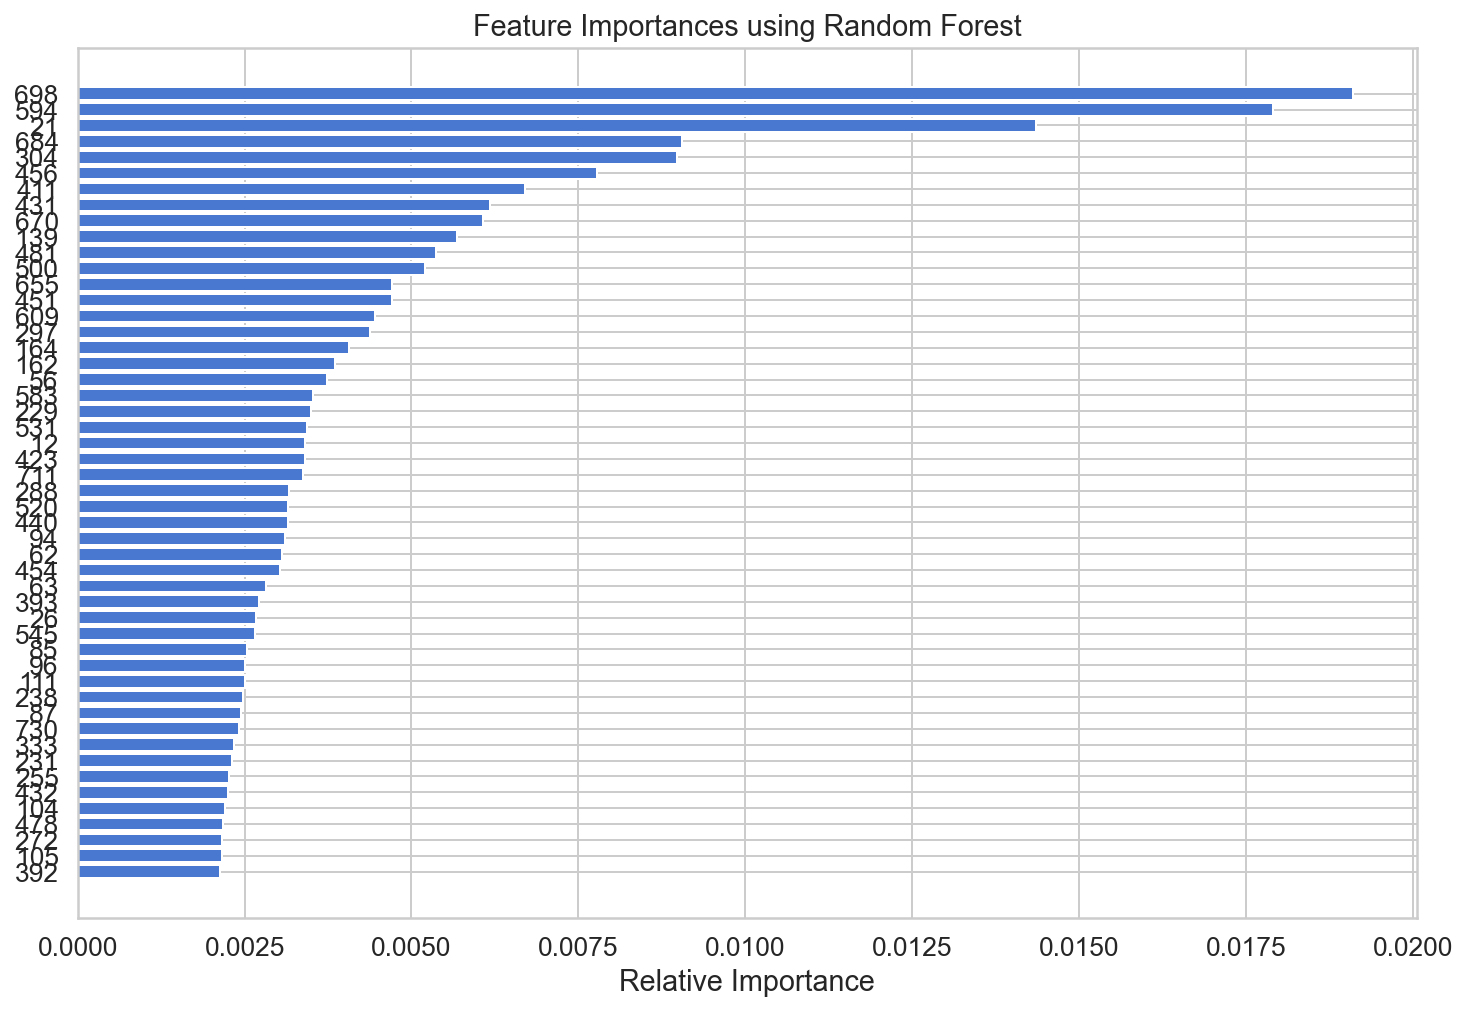

In [106]:
importances_RF = Fit_RF.feature_importances_
indices_RF = np.argsort(importances_RF)[-50:]  # top 50 features
print(len(indices_RF))
plt.title('Feature Importances using Random Forest')
plt.barh(range(len(indices_RF)), importances_RF[indices_RF], color='b', align='center')
plt.yticks(range(len(indices_RF)), [indices_RF[i] for i in range(len(indices_RF))])
plt.xlabel('Relative Importance')
plt.show()

In [109]:
reduced_encoded_text_RF = np.delete(encoded_text, [indices_RF], 1)
print(reduced_encoded_text_RF)

[[ 0.24509159  0.19708309  0.29548106 ... -0.29075688  0.72883326
   0.44577336]
 [ 0.09723976  0.09622154 -0.26650718 ... -0.23062071  0.48081025
   0.5357829 ]
 [-0.32416722 -0.10876965 -0.57410985 ... -0.13799219  0.5594007
   0.49791324]
 ...
 [-0.6389676  -0.38434893 -0.39575297 ... -0.51342124  0.54426205
   0.49297243]
 [-0.24634935 -0.35067943  0.18437135 ... -0.3237255   0.7697916
   0.07015157]
 [-0.49031657 -0.47751486 -0.62413853 ... -0.5154614   0.5796705
   0.18884005]]


In [110]:
print(len(reduced_encoded_text_RF[1]))

718


In [114]:
importances = Fit.feature_importances_
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import time
for i in range (1,15):
    indices_RF = np.argsort(importances_RF)[-(i*50)-18:]  # top i*50 features
    reduced_encoded_text_RF = np.delete(encoded_text, [indices_RF], 1)
    print(len(reduced_encoded_text_RF[1]))
    X_train_RF, X_test_RF, train_labels_RF, test_labels_RF = train_test_split(reduced_encoded_text_RF, labels,random_state=42)
    svc_clf_RF = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    svc_clf_RF.fit(X_train_RF,train_labels_RF)
    svc_RF_score=svc_clf_RF.score(X_test_RF, test_labels_RF)
    print(svc_RF_score)

700
0.6995
650
0.6985
600
0.696
550
0.6895
500
0.689
450
0.6875
400
0.6865
350
0.682
300
0.6755
250
0.6595
200
0.656
150
0.638
100
0.6135
50
0.5825


## XGBoost

In [121]:
features=pd.DataFrame(data = x)
from xgboost import XGBClassifier
model_XGB = XGBClassifier() #xgbosot dont have max_feature api, reference:https://xgboost.readthedocs.io/en/latest/python/python_api.html
Fit_XGB = model_XGB.fit(features, y)

[20:39:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


50


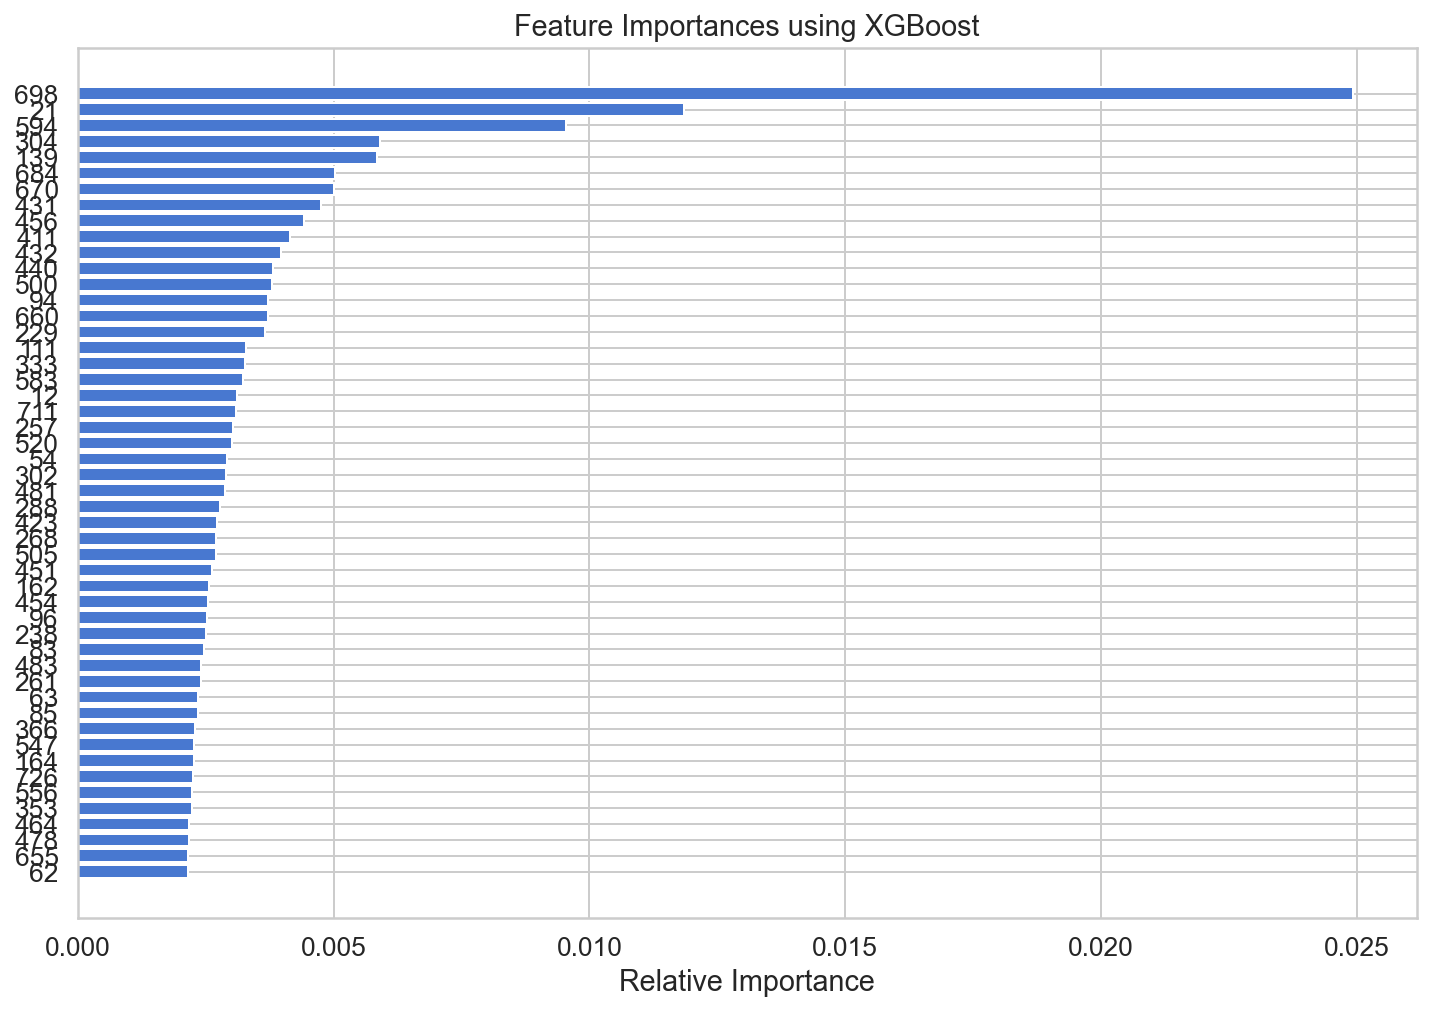

In [122]:
importances_XGB = Fit_XGB.feature_importances_
indices_XGB = np.argsort(importances_XGB)[-50:]  # top 50 features
print(len(indices_XGB))
plt.title('Feature Importances using XGBoost')
plt.barh(range(len(indices_XGB)), importances_XGB[indices_XGB], color='b', align='center')
plt.yticks(range(len(indices_XGB)), [indices_XGB[i] for i in range(len(indices_XGB))])
plt.xlabel('Relative Importance')
plt.show()

In [123]:
reduced_encoded_text_XGB = np.delete(encoded_text, [indices_XGB], 1)
print(reduced_encoded_text_XGB)

[[ 0.24509159  0.19708309  0.29548106 ... -0.29075688  0.72883326
   0.44577336]
 [ 0.09723976  0.09622154 -0.26650718 ... -0.23062071  0.48081025
   0.5357829 ]
 [-0.32416722 -0.10876965 -0.57410985 ... -0.13799219  0.5594007
   0.49791324]
 ...
 [-0.6389676  -0.38434893 -0.39575297 ... -0.51342124  0.54426205
   0.49297243]
 [-0.24634935 -0.35067943  0.18437135 ... -0.3237255   0.7697916
   0.07015157]
 [-0.49031657 -0.47751486 -0.62413853 ... -0.5154614   0.5796705
   0.18884005]]


In [124]:
print(len(reduced_encoded_text_XGB[1]))

718


In [125]:
importances = Fit.feature_importances_
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import time
for i in range (1,15):
    indices_XGB = np.argsort(importances_XGB)[-(i*50)-18:]  # top i*50 features
    reduced_encoded_text_XGB = np.delete(encoded_text, [indices_XGB], 1)
    print(len(reduced_encoded_text_XGB[1]))
    X_train_XGB, X_test_XGB, train_labels_XGB, test_labels_XGB = train_test_split(reduced_encoded_text_XGB, labels,random_state=42)
    svc_clf_XGB = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    svc_clf_XGB.fit(X_train_XGB,train_labels_XGB)
    svc_XGB_score=svc_clf_XGB.score(X_test_XGB, test_labels_XGB)
    print(svc_XGB_score)

700
0.7025
650
0.7035
600
0.695
550
0.698
500
0.6955
450
0.6915
400
0.6915
350
0.691
300
0.6795
250
0.6745
200
0.6725
150
0.6675
100
0.6505
50
0.5795
